In [2]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# 시각화 설정 (한글 깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 사용자
# plt.rcParams['font.family'] = 'AppleGothic' # Mac 사용자
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 크롤링된 파일명 입력
# 예: reviews_1562700_200_{app_id}.json
filename_input = input("분석할 JSON 파일명을 입력하세요: ")

if not filename_input.lower().endswith('.json'):
    filename = filename_input + '.json'
else:
    filename = filename_input

base_path = "../dataSet"
full_path = os.path.join(base_path, filename)
absolute_path = os.path.abspath(full_path)
print(f"로드할 파일 경로: {absolute_path}")

try:
    with open(absolute_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # JSON 구조에 따라 데이터 로드 방식 변경 (리뷰 리스트가 'reviews' 키 아래에 있다고 가정)
    reviews_data = data.get('reviews', data) if isinstance(data, dict) else data
    df = pd.DataFrame(reviews_data)
    
    # 게임 이름 추출 (파일명을 기준으로)
    game_name = filename.split('_')[-1].replace('.json', '')
    
    print(f"✅ '{game_name}' 데이터 로드 완료. 총 리뷰 수: {len(df)}개")
    print("\n--- 데이터 미리보기 ---")
    print(df.head())

except FileNotFoundError:
    print(f"❌ 오류: 파일을 찾을 수 없습니다: {full_path}. 경로를 확인해 주세요.")
    df = pd.DataFrame()
except Exception as e:
    print(f"❌ 데이터 로드 중 오류 발생: {e}")
    df = pd.DataFrame()

분석할 JSON 파일명을 입력하세요:  reviews_3932890_200_escape_from_tarkov


로드할 파일 경로: C:\Users\taho0\testcode\NLP_Project\dataSet\reviews_3932890_200_escape_from_tarkov.json
✅ 'tarkov' 데이터 로드 완료. 총 리뷰 수: 200개

--- 데이터 미리보기 ---
   review_id          author_id  playtime_forever  \
0  210750440  76561199233254656               667   
1  210720493  76561198288230154              6263   
2  210698858  76561198001565681             11002   
3  210672919  76561198028063750                50   
4  210590466  76561198083325898              1765   

                                         review_text  voted_up  
0                                                어려움      True  
1                                     속보) 쇼어라인 앞바다에서      True  
2  시간 녹이기류 최강겜. \r\n서버 개똥같고 기껏 힘줘서 무장해도 핵한테 똥탄 한방...      True  
3  구입했더니 captcha 문제로 접속 불가능\n\n---\n\n꾸역꾸역 vpn 으로...     False  
4                                 서버 가 핑 이 매칭 이 쓰레기임     False  


In [19]:
# 성향별 키워드 사전 정의
KEYWORDS = {
    "narrative": ["스토리", "서사", "감동", "엔딩", "캐릭터", "몰입", "대사", "연출", "배경"],
    "freedom": ["자유도", "오픈월드", "탐험", "상호작용", "선택", "커스터마이징", "비선형"],
    "stability": ["최적화", "버그", "프레임", "렉", "튕김", "서버", "운영", "잔렉", "불안정"],
    "challenge": ["난이도", "컨트롤", "보스", "피지컬", "패턴", "도전", "소울", "어려움", "노력"]
}

def calculate_persona_vector(review_text):
    """단일 리뷰 텍스트를 분석하여 성향 벡터 (4축 점수)를 반환합니다."""
    scores = {k: 0 for k in KEYWORDS.keys()}
    total_hits = 0
    
    if pd.isna(review_text):
        return {k: 0.0 for k in KEYWORDS.keys()}

    # 텍스트 내 키워드 카운팅
    for category, words in KEYWORDS.items():
        for word in words:
            # 정규 표현식을 사용하여 해당 단어의 출현 횟수 카운트
            count = len(re.findall(word, review_text, re.IGNORECASE))
            scores[category] += count
            total_hits += count
            
    # 정규화 (전체 합이 1이 되도록 비중 계산)
    if total_hits == 0:
        return {k: 0.0 for k in KEYWORDS.keys()}
    
    persona_vector = {k: round(v / total_hits, 3) for k, v in scores.items()}
    return persona_vector

In [25]:
# 각 리뷰 텍스트에 함수 적용하여 'persona_vector' 컬럼 생성
if not df.empty:
    df['persona_vector'] = df['review_text'].apply(calculate_persona_vector)

    # 벡터 딕셔너리를 개별 컬럼으로 분리
    vector_df = df['persona_vector'].apply(pd.Series)
    vector_df.columns = ['S_' + col for col in vector_df.columns]
    df = pd.concat([df, vector_df], axis=1)

    print("\n✅ 성향 벡터 계산 완료.")
    print(df[['review_text', 'S_narrative', 'S_freedom', 'S_stability', 'S_challenge']].head(4))
else:
    print("분석할 DataFrame이 비어 있어 성향 벡터 계산을 건너뜁니다.")


✅ 성향 벡터 계산 완료.
                                         review_text  S_narrative  \
0                                                어려움          0.0   
1                                     속보) 쇼어라인 앞바다에서          0.0   
2  시간 녹이기류 최강겜. \r\n서버 개똥같고 기껏 힘줘서 무장해도 핵한테 똥탄 한방...          0.0   
3  구입했더니 captcha 문제로 접속 불가능\n\n---\n\n꾸역꾸역 vpn 으로...          0.0   

   S_narrative  S_narrative  S_freedom  S_freedom  S_freedom  S_stability  \
0          0.0          0.0        0.0        0.0        0.0          0.0   
1          0.0          0.0        0.0        0.0        0.0          0.0   
2          0.0          0.0        0.0        0.0        0.0          1.0   
3          0.0          0.0        0.0        0.0        0.0          0.0   

   S_stability  S_stability  S_challenge  S_challenge  S_challenge  
0          0.0          0.0          1.0          1.0          1.0  
1          0.0          0.0          0.0          0.0          0.0  
2          1.0          1.0          0.0     

C:\Users\taho0\AppData\Local\Temp\ipykernel_8664\1424227920.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_persona.index, y=average_persona.values, palette="viridis")


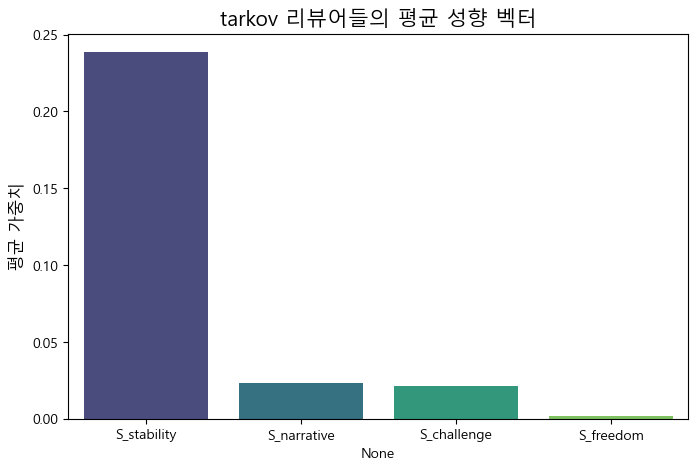

In [21]:
# 성향 컬럼들만 선택하여 평균 계산
if not df.empty:
    persona_columns = ['S_narrative', 'S_freedom', 'S_stability', 'S_challenge']
    average_persona = df[persona_columns].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(8, 5))

    sns.barplot(
        x=average_persona.index, 
        y=average_persona.values, 
        hue=average_persona.index, # x 변수를 hue에 할당
        palette="viridis",
        legend=False # 범례(legend)는 필요 없으므로 False로 설정
    )

    sns.barplot(x=average_persona.index, y=average_persona.values, palette="viridis")
    plt.title(f'{game_name} 리뷰어들의 평균 성향 벡터', fontsize=15)
    plt.ylabel('평균 가중치', fontsize=12)
    plt.xticks(rotation=0)
    plt.show()

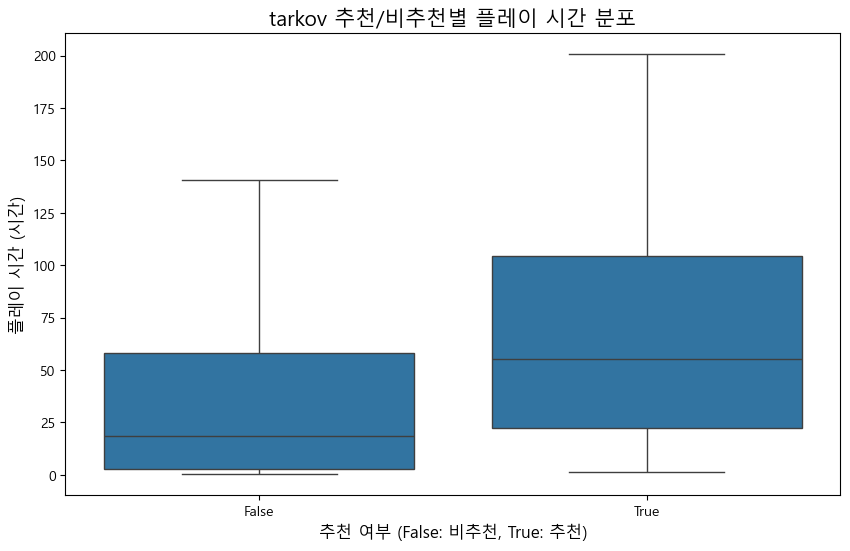

In [22]:
# 플레이 시간을 시간 단위로 변환
if not df.empty:
    df['playtime_hours'] = df['playtime_forever'] / 60
    
    # 플레이 시간에 따른 분위기 파악
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='voted_up', y='playtime_hours', data=df, showfliers=False) # 이상치 제외
    plt.title(f'{game_name} 추천/비추천별 플레이 시간 분포', fontsize=15)
    plt.xlabel('추천 여부 (False: 비추천, True: 추천)', fontsize=12)
    plt.ylabel('플레이 시간 (시간)', fontsize=12)
    plt.show()

In [23]:
if not df.empty:
    # 분석 결과 파일 경로 생성
    output_csv_filename = f"analyzed_{game_name}_reviews.csv"
    output_full_path = os.path.join(base_path, output_csv_filename)
    absolute_full_path = os.path.abspath(output_full_path)
    df.to_csv(absolute_full_path, index=False, encoding='utf-8')
    print(f"\n📂 분석 결과가 '{absolute_full_path}' 파일에 저장되었습니다.")


📂 분석 결과가 'C:\Users\taho0\testcode\NLP_Project\dataSet\analyzed_tarkov_reviews.csv' 파일에 저장되었습니다.
